In [1]:
# Importing Libraries
# We will use the following libraries:
# - `pandas` for data manipulation
# - `numpy` for numerical operations
# - `matplotlib` and `seaborn` for visualization
# - `sklearn` for the implementation of decision trees

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix

In [11]:
dataframe = pd.read_csv('data_resampled.csv')
# Display the first few rows of the dataframe
print(dataframe.head())
# Display the shape of the dataframe
print(dataframe.shape)

   Application order  Daytime/evening attendance  \
0                  5                           1   
1                  1                           1   
2                  5                           1   
3                  2                           1   
4                  1                           0   

   Previous qualification (grade)  Admission grade  Displaced  Debtor  \
0                           122.0            127.3          1       0   
1                           160.0            142.5          1       0   
2                           122.0            124.8          1       0   
3                           122.0            119.6          1       0   
4                           100.0            141.5          0       0   

   Tuition fees up to date  Gender  Scholarship holder  Age at enrollment  \
0                        1       1                   0                 20   
1                        0       1                   0                 19   
2                

In [ ]:
# Load the dataset
dataframe = pd.read_csv(r"d.csv",sep=';')
dataframe.head(10)

# convert the dataframe to a a pandas dataframe for easier manipulation
dataframe = pd.DataFrame(dataframe)

# target variable
target = dataframe['Target']

# features
features = dataframe.drop(columns=['Target'])

target.isna().sum()
# contAR TARGET TYPE
target.value_counts()

KeyError: 'target'

In [18]:
target = dataframe['Target']
target_names = ['Dropout', 'Enrolled', 'Graduate']
features = dataframe.drop(columns=['Target'])


# ✅ Fase 1: Estandarizar variables continuas (float64) con Z-score

In [17]:
from sklearn.preprocessing import StandardScaler

float_cols = [
    'Previous qualification (grade)',
    'Admission grade',
    'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (grade)',
    'Unemployment rate',
    'Inflation rate',
    'GDP'
]

scaler = StandardScaler()
features[float_cols] = scaler.fit_transform(features[float_cols])


#  Fase 2: División del dataset: 80% train / 20% test

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from graphviz import Source

# Asignar correctamente
X = features
y =  target
target_names = ['Dropout', 'Enrolled', 'Graduate']

# División 80/20 con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## GINI depth: 3

GINI TREE, depth=3
Accuracy: 0.70

Confusion matrix:
[[288  99  53]
 [ 65 219 116]
 [ 22  48 430]]

Classification report:
              precision    recall  f1-score   support

     Dropout       0.77      0.65      0.71       440
    Enrolled       0.60      0.55      0.57       400
    Graduate       0.72      0.86      0.78       500

    accuracy                           0.70      1340
   macro avg       0.69      0.69      0.69      1340
weighted avg       0.70      0.70      0.69      1340



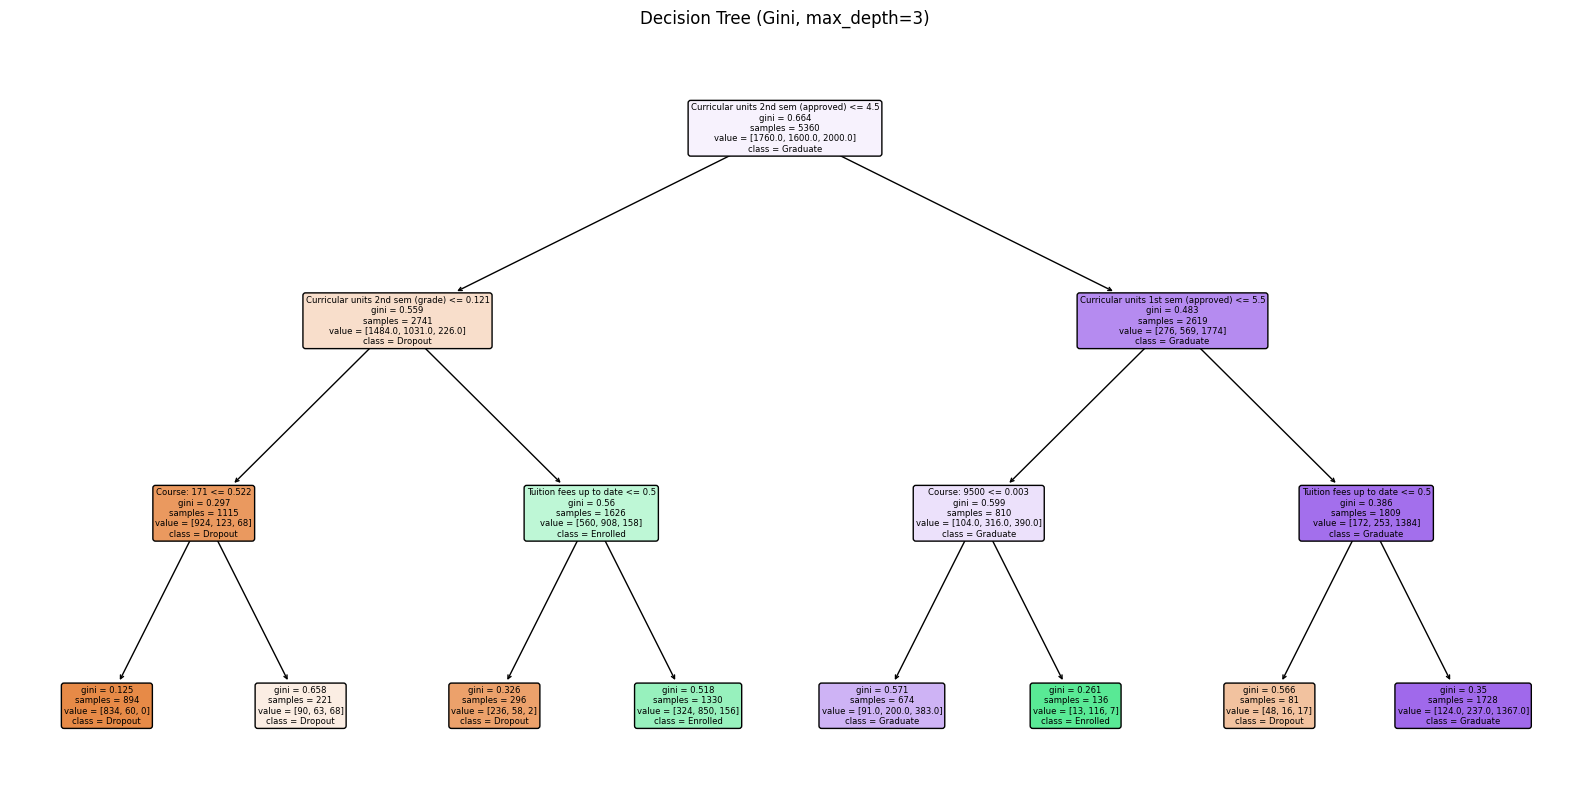

In [20]:
print("GINI TREE, depth=3")
# Crear y entrenar el árbol
clf_gini1 = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)
clf_gini1.fit(X_train, y_train)

# Predicciones
y_pred = clf_gini1.predict(X_test)

# Evaluación
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(clf_gini1, feature_names=features.columns, class_names=target_names, filled=True, rounded=True)
# save the tree in svg format
plt.savefig("tree_gini3.svg", format='svg')
plt.title("Decision Tree (Gini, max_depth=3)")
plt.show()


# GINI depth: 5

GINI TREE, depth=5
Accuracy: 0.71

Confusion matrix:
[[275 108  57]
 [ 45 237 118]
 [ 10  53 437]]

Classification report:
              precision    recall  f1-score   support

     Dropout       0.83      0.62      0.71       440
    Enrolled       0.60      0.59      0.59       400
    Graduate       0.71      0.87      0.79       500

    accuracy                           0.71      1340
   macro avg       0.71      0.70      0.70      1340
weighted avg       0.72      0.71      0.71      1340



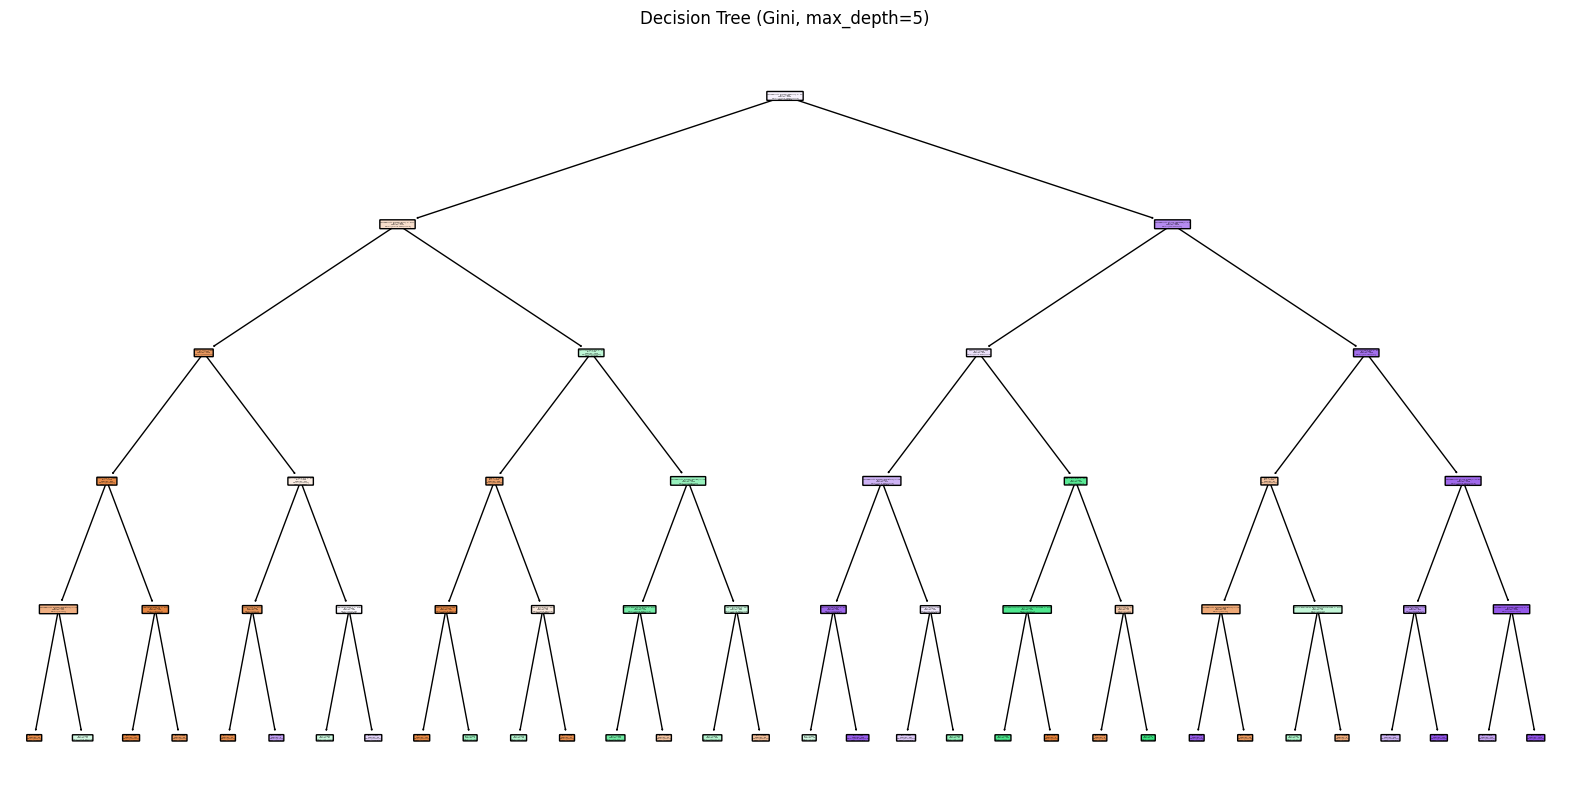

In [21]:
print("GINI TREE, depth=5")
# Crear y entrenar el árbol
clf_gini2 = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
clf_gini2.fit(X_train, y_train)

# Predicciones
y_pred = clf_gini2.predict(X_test)

# Evaluación
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(clf_gini2, feature_names=features.columns, class_names=target_names, filled=True, rounded=True)
plt.title("Decision Tree (Gini, max_depth=5)")
# save the tree in svg format
plt.savefig("tree_gini5.svg", format='svg')
plt.show()




## entropia depth: 3

ENTROPY TREE, depth=3
Accuracy: 0.70

Confusion matrix:
[[295  96  49]
 [ 56 210 134]
 [ 21  47 432]]

Classification report:
              precision    recall  f1-score   support

     Dropout       0.79      0.67      0.73       440
    Enrolled       0.59      0.53      0.56       400
    Graduate       0.70      0.86      0.77       500

    accuracy                           0.70      1340
   macro avg       0.70      0.69      0.69      1340
weighted avg       0.70      0.70      0.69      1340



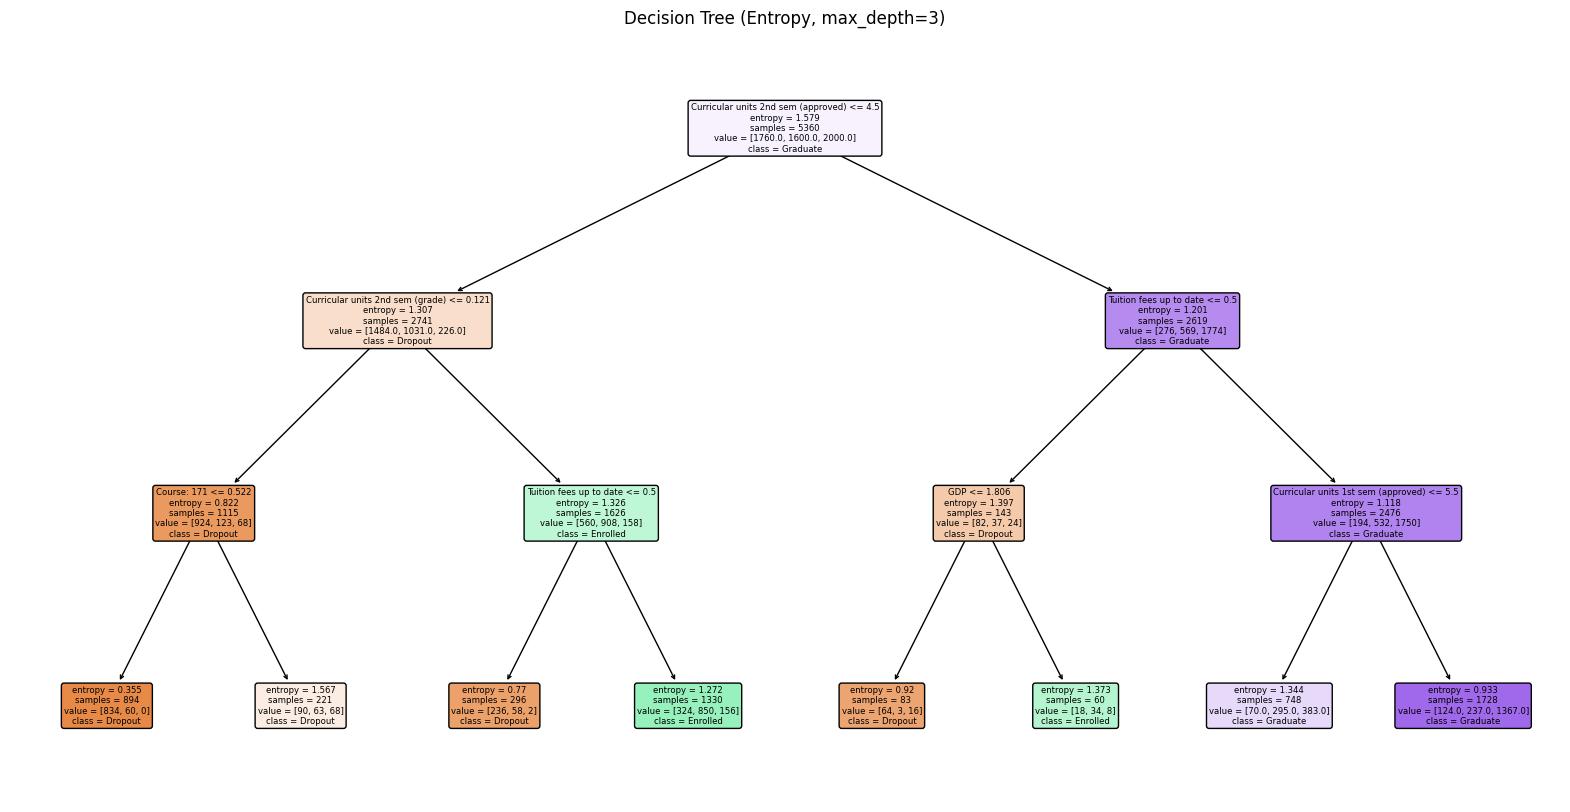

In [22]:
print("ENTROPY TREE, depth=3")
# crear y entrenar el árbol
clf_entropy3 = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)
clf_entropy3.fit(X_train, y_train)

# predicciones
y_pred = clf_entropy3.predict(X_test)

# evaluación
accuracy = accuracy_score(y_test, y_pred) 
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(clf_entropy3, feature_names=features.columns, class_names=target_names, filled=True, rounded=True)
plt.title("Decision Tree (Entropy, max_depth=3)")
# save the tree in svg format
plt.savefig("tree_entropy3.svg", format='svg')
plt.show()

ENTROPY TREE, depth=5
Accuracy: 0.72

Confusion matrix:
[[275 112  53]
 [ 30 250 120]
 [  6  56 438]]

Classification report:
              precision    recall  f1-score   support

     Dropout       0.88      0.62      0.73       440
    Enrolled       0.60      0.62      0.61       400
    Graduate       0.72      0.88      0.79       500

    accuracy                           0.72      1340
   macro avg       0.73      0.71      0.71      1340
weighted avg       0.74      0.72      0.72      1340



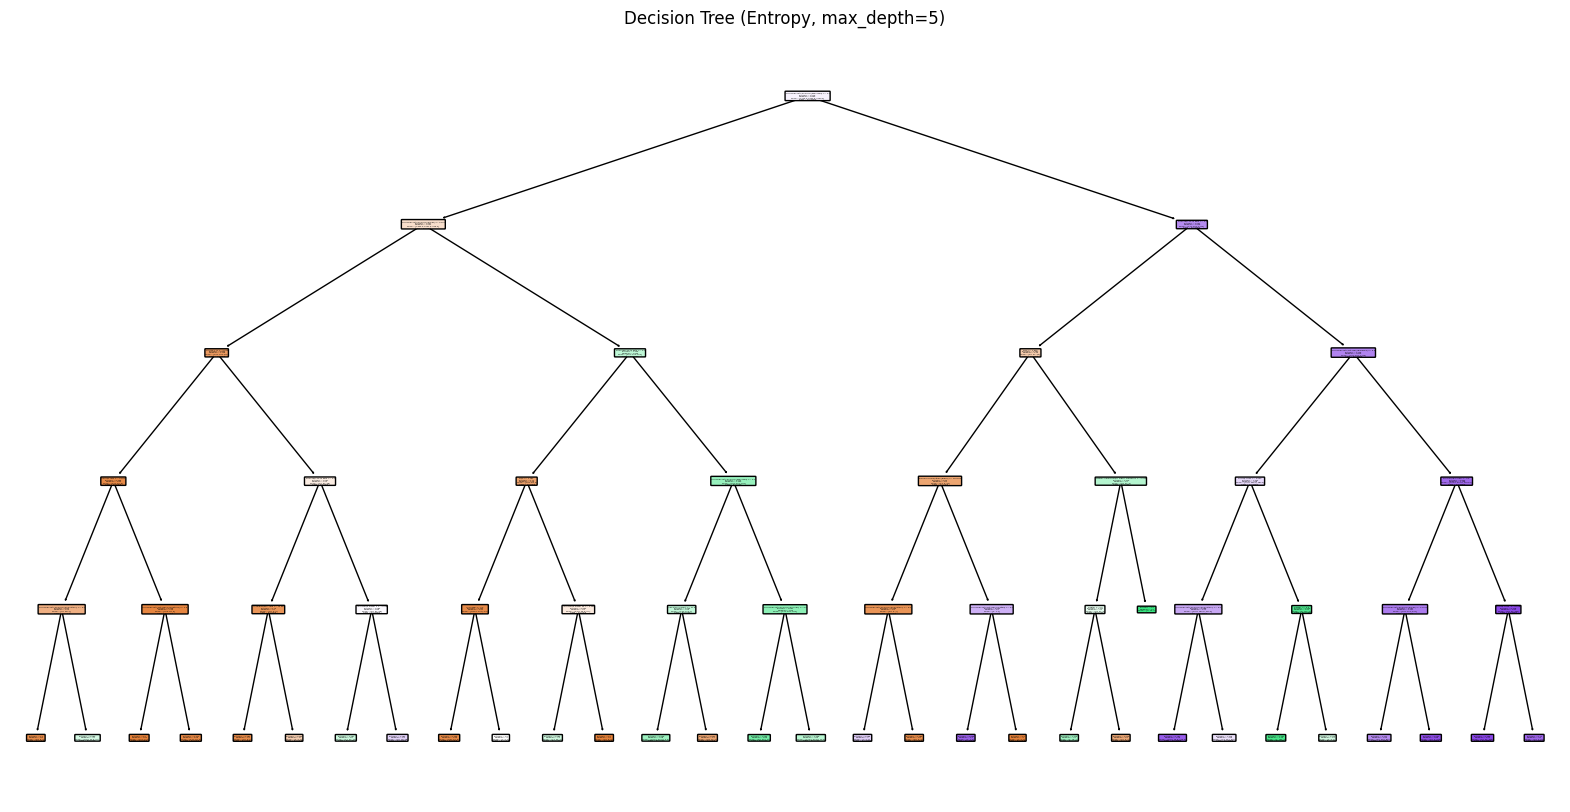

In [23]:
print("ENTROPY TREE, depth=5")
# crear y entrenar el árbol
clf_entropy5 = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
clf_entropy5.fit(X_train, y_train)

# predicciones
y_pred = clf_entropy5.predict(X_test)

# evaluación
accuracy = accuracy_score(y_test, y_pred) 
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(clf_entropy5, feature_names=features.columns, class_names=target_names, filled=True, rounded=True)
plt.title("Decision Tree (Entropy, max_depth=5)")
# save the tree in svg format
plt.savefig("tree_entropy5.svg", format='svg')
plt.show()

ENTROPY TREE, depth=5
Accuracy: 0.72

Confusion matrix:
[[273 113  54]
 [ 30 250 120]
 [  7  56 437]]

Classification report:
              precision    recall  f1-score   support

     Dropout       0.88      0.62      0.73       440
    Enrolled       0.60      0.62      0.61       400
    Graduate       0.72      0.87      0.79       500

    accuracy                           0.72      1340
   macro avg       0.73      0.71      0.71      1340
weighted avg       0.73      0.72      0.71      1340



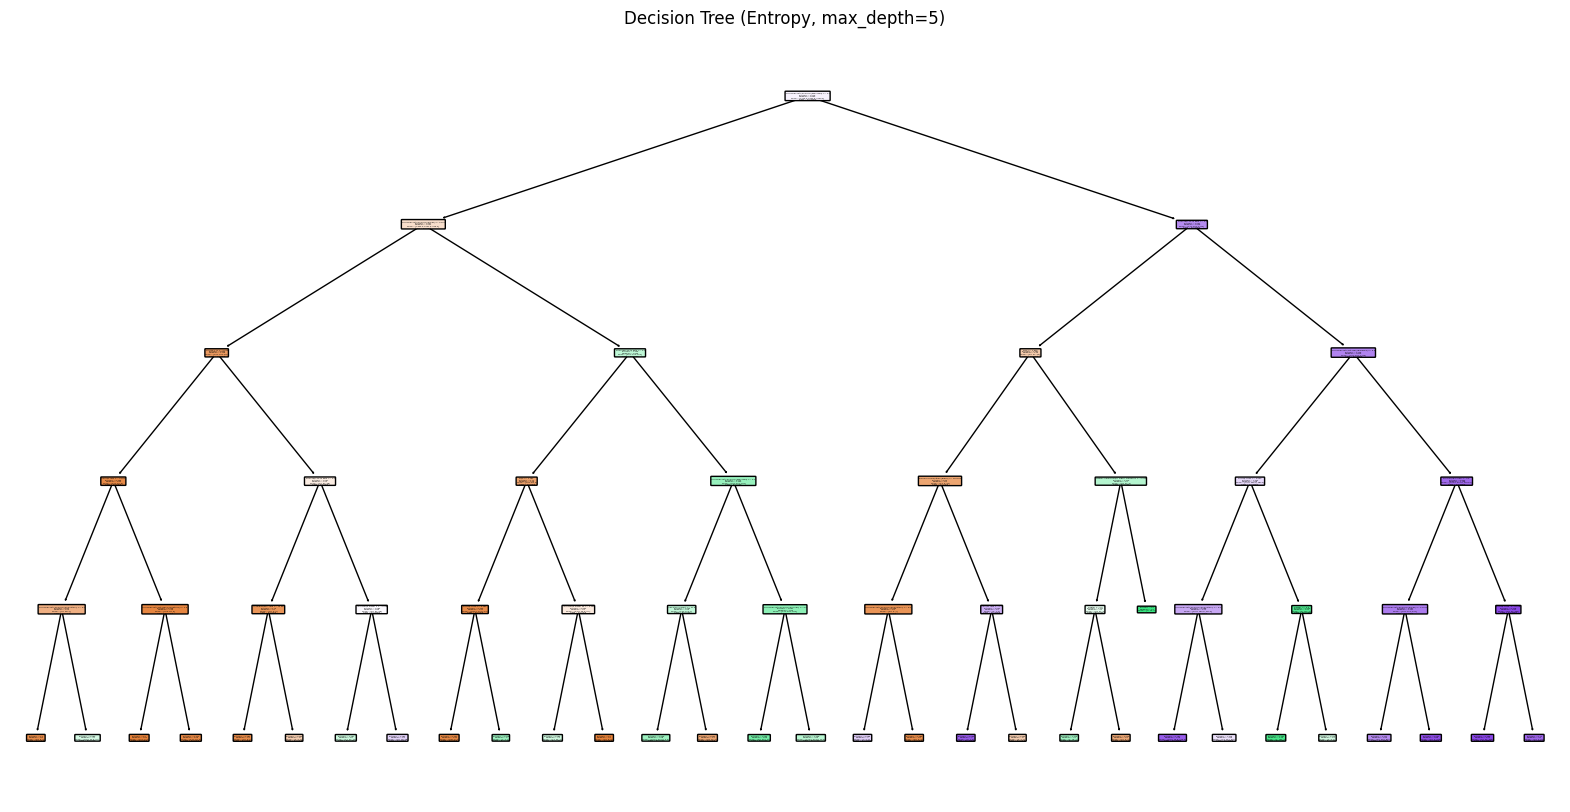

In [25]:
print("ENTROPY TREE, depth=5")
# crear y entrenar el árbol
clf_entropy51 =DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5,
    min_samples_leaf=5,             # nuevo: evita hojas con muy pocos ejemplos
    min_impurity_decrease=0.001,    # nuevo: impide splits poco informativos
    random_state=42
)
clf_entropy51.fit(X_train, y_train)

# predicciones
y_pred = clf_entropy51.predict(X_test)

# evaluación
accuracy = accuracy_score(y_test, y_pred) 
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(clf_entropy51, feature_names=features.columns, class_names=target_names, filled=True, rounded=True)
plt.title("Decision Tree (Entropy, max_depth=5)")
# save the tree in svg format
plt.savefig("tree_entropy5.svg", format='svg')
plt.show()

Aunque las métricas cuantitativas permanecen prácticamente idénticas, el valor diferencial radica en que el árbol regularizado:

- Es estructuralmente más limpio, con menos nodos redundantes.

- Elimina divisiones innecesarias que apenas aportan reducción de entropía.

- Evita hojas con pocos ejemplos, que suelen ser propensas a errores por ruido o outliers.

Esto hace que el modelo resultante sea más interpretable, más robusto y menos sensible a variaciones leves en los datos.

A pesar de que ambos árboles tienen el mismo rendimiento en términos de precisión y equilibrio entre clases, la versión con regularización adicional ofrece ventajas cualitativas clave. Su estructura es más compacta y menos propensa al sobreajuste, lo que facilita la interpretación de reglas de decisión y la justificación de acciones académicas. Este modelo resulta, por tanto, más apropiado para ser integrado en una herramienta de apoyo al seguimiento estudiantil, donde la simplicidad, transparencia y estabilidad son tan importantes como la precisión.

